In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [15]:
from sklearn.decomposition import PCA

In [17]:
# Load the dataset
df = pd.read_excel("Online_retail.xlsx")

In [18]:
# Preprocessing
df.dropna(subset=['CustomerID'], inplace=True)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [19]:
# RFM Calculation
latest_date = df['InvoiceDate'].max()
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [20]:
# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [21]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)
rfm['PCA-1'] = pca_result[:, 0]
rfm['PCA-2'] = pca_result[:, 1]

In [24]:
# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [25]:
# t-SNE for 3D Visualization
tsne = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=3000)
tsne_results = tsne.fit_transform(rfm_scaled)

In [26]:
# Create a DataFrame for visualization
rfm['TSNE-1'] = tsne_results[:, 0]
rfm['TSNE-2'] = tsne_results[:, 1]
rfm['TSNE-3'] = tsne_results[:, 2]

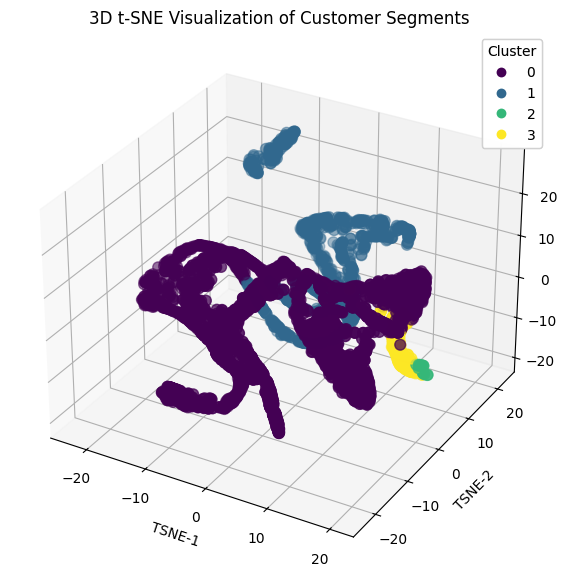

In [27]:
# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm['TSNE-1'], rfm['TSNE-2'], rfm['TSNE-3'],
                     c=rfm['Cluster'], cmap='viridis', s=60)
ax.set_title('3D t-SNE Visualization of Customer Segments')
ax.set_xlabel('TSNE-1')
ax.set_ylabel('TSNE-2')
ax.set_zlabel('TSNE-3')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.show()

In [28]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
Cluster,,,
0,42.702685,3.682711,1359.049284
1,247.075914,1.552015,480.617480
2,6.384615,82.538462,127338.313846
3,14.500000,22.333333,12709.090490


In [29]:
# Save to CSV
rfm.to_csv("Customer_Segments.csv", index=False)
print("✅ Clustered customer data saved to 'Customer_Segments.csv'")

✅ Clustered customer data saved to 'Customer_Segments.csv'


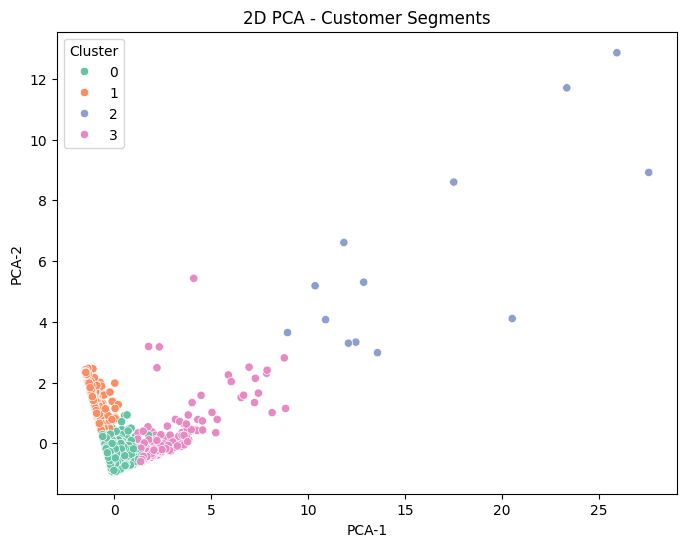

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# Create PCA DataFrame and include the cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA-1', 'PCA-2'])
pca_df['Cluster'] = rfm['Cluster'].values  # ✅ Important: attach cluster labels

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA-1', y='PCA-2', hue='Cluster', palette='Set2')
plt.title('2D PCA - Customer Segments')
plt.show()


In [35]:
import pandas as pd
from itertools import combinations
from collections import Counter

# Load your dataset
df = pd.read_excel("Online_retail.xlsx")

# Drop missing values and duplicates for safety
df.dropna(subset=['InvoiceNo', 'Description'], inplace=True)
df.drop_duplicates(inplace=True)

# Group items by Invoice
invoice_products = df.groupby('InvoiceNo')['Description'].apply(list)

# Create a Counter for product pairs
pair_counter = Counter()

# Count all product pairs in each invoice
for products in invoice_products:
    # Get unique pairs from the invoice
    pairs = combinations(sorted(set(products)), 2)
    pair_counter.update(pairs)

# Get top 10 most common product pairs
top_10_pairs = pair_counter.most_common(10)

# Display the result
print("Top 10 Products Frequently Bought Together:\n")
for pair, count in top_10_pairs:
    print(f"{pair[0]} & {pair[1]} — {count} times")


Top 10 Products Frequently Bought Together:

JUMBO BAG PINK POLKADOT & JUMBO BAG RED RETROSPOT — 833 times
GREEN REGENCY TEACUP AND SAUCER & ROSES REGENCY TEACUP AND SAUCER  — 784 times
JUMBO BAG RED RETROSPOT & JUMBO STORAGE BAG SUKI — 733 times
JUMBO BAG RED RETROSPOT & JUMBO SHOPPER VINTAGE RED PAISLEY — 683 times
LUNCH BAG  BLACK SKULL. & LUNCH BAG RED RETROSPOT — 648 times
ALARM CLOCK BAKELIKE GREEN & ALARM CLOCK BAKELIKE RED  — 646 times
GREEN REGENCY TEACUP AND SAUCER & PINK REGENCY TEACUP AND SAUCER — 644 times
PINK REGENCY TEACUP AND SAUCER & ROSES REGENCY TEACUP AND SAUCER  — 614 times
LUNCH BAG PINK POLKADOT & LUNCH BAG RED RETROSPOT — 613 times
JUMBO  BAG BAROQUE BLACK WHITE & JUMBO BAG RED RETROSPOT — 593 times


In [36]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Most Sold Products:\n", top_products)

Top 10 Most Sold Products:
 Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53751
JUMBO BAG RED RETROSPOT               47260
POPCORN HOLDER                        36322
ASSORTED COLOUR BIRD ORNAMENT         36282
PACK OF 72 RETROSPOT CAKE CASES       36016
WHITE HANGING HEART T-LIGHT HOLDER    35298
RABBIT NIGHT LIGHT                    30631
MINI PAINT SET VINTAGE                26437
PACK OF 12 LONDON TISSUES             26299
PACK OF 60 PINK PAISLEY CAKE CASES    24719
Name: Quantity, dtype: int64


In [37]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
top_revenue_products = df.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(10)
print("Top 10 Revenue-Generating Products:\n", top_revenue_products)


Top 10 Revenue-Generating Products:
 Description
DOTCOM POSTAGE                        206245.48
REGENCY CAKESTAND 3 TIER              164459.49
WHITE HANGING HEART T-LIGHT HOLDER     99612.42
PARTY BUNTING                          98243.88
JUMBO BAG RED RETROSPOT                92175.79
RABBIT NIGHT LIGHT                     66661.63
POSTAGE                                66230.64
PAPER CHAIN KIT 50'S CHRISTMAS         63715.24
ASSORTED COLOUR BIRD ORNAMENT          58792.42
CHILLI LIGHTS                          53746.66
Name: TotalRevenue, dtype: float64


In [38]:
top_customers = df['CustomerID'].value_counts().head(10)
print("Top 10 Most Active Customers:\n", top_customers)


Top 10 Most Active Customers:
 CustomerID
17841.0    7812
14911.0    5898
14096.0    5128
12748.0    4459
14606.0    2759
15311.0    2478
14646.0    2085
13089.0    1853
13263.0    1667
14298.0    1640
Name: count, dtype: int64


In [39]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
hourly_sales = df.groupby('Hour')['Quantity'].sum()
print("Sales by Hour:\n", hourly_sales)


Sales by Hour:
 Hour
6        -86
7      15361
8     157728
9     429395
10    682524
11    639240
12    816528
13    677110
14    570693
15    609825
16    312431
17    164742
18     60580
19     31851
20      8189
Name: Quantity, dtype: int64


In [40]:
country_revenue = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending=False)
print("Revenue by Country:\n", country_revenue.head(10))


Revenue by Country:
 Country
United Kingdom    8167128.184
Netherlands        284661.540
EIRE               262993.380
Germany            221509.470
France             197317.110
Australia          137009.770
Switzerland         56363.050
Spain               54756.030
Belgium             40910.960
Sweden              36585.410
Name: TotalRevenue, dtype: float64


In [41]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 1: Preprocess Data
df = pd.read_excel("Online_retail.xlsx")
df.dropna(subset=['InvoiceNo', 'Description', 'CustomerID'], inplace=True)
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

# Step 2: Create Customer-Level Features
customer_df = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalRevenue': 'sum',
    'InvoiceNo': pd.Series.nunique,
    'Description': pd.Series.nunique
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'TotalRevenue': 'TotalRevenue',
    'InvoiceNo': 'NumTransactions',
    'Description': 'NumUniqueProducts'
}).reset_index()

# Step 3: Scale the Data
features = ['TotalQuantity', 'TotalRevenue', 'NumTransactions', 'NumUniqueProducts']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])

# Step 4: Apply Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
customer_df['Anomaly'] = iso_forest.fit_predict(X_scaled)

# Step 5: Extract Anomalous Customers
anomalous_customers = customer_df[customer_df['Anomaly'] == -1]['CustomerID']
print("Anomalous Customer IDs:\n", anomalous_customers.to_list())


Anomalous Customer IDs:
 [12357.0, 12359.0, 12362.0, 12378.0, 12409.0, 12415.0, 12428.0, 12431.0, 12433.0, 12435.0, 12437.0, 12451.0, 12471.0, 12472.0, 12474.0, 12476.0, 12477.0, 12481.0, 12484.0, 12500.0, 12524.0, 12536.0, 12540.0, 12557.0, 12567.0, 12569.0, 12583.0, 12584.0, 12590.0, 12619.0, 12621.0, 12626.0, 12637.0, 12664.0, 12678.0, 12681.0, 12682.0, 12683.0, 12688.0, 12700.0, 12705.0, 12709.0, 12712.0, 12714.0, 12720.0, 12731.0, 12744.0, 12748.0, 12752.0, 12753.0, 12754.0, 12757.0, 12766.0, 12798.0, 12830.0, 12839.0, 12841.0, 12867.0, 12875.0, 12901.0, 12921.0, 12931.0, 12939.0, 12955.0, 12957.0, 12971.0, 12980.0, 12989.0, 13001.0, 13004.0, 13014.0, 13018.0, 13027.0, 13047.0, 13050.0, 13069.0, 13078.0, 13081.0, 13082.0, 13089.0, 13090.0, 13093.0, 13094.0, 13097.0, 13098.0, 13102.0, 13113.0, 13124.0, 13135.0, 13137.0, 13148.0, 13174.0, 13178.0, 13198.0, 13199.0, 13209.0, 13225.0, 13230.0, 13256.0, 13263.0, 13266.0, 13267.0, 13268.0, 13269.0, 13316.0, 13319.0, 13324.0, 13334.0, 13

In [43]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [42]:
df = pd.read_excel('Online_retail.xlsx')

In [44]:
df.dropna(subset=['InvoiceNo', 'Description', 'CustomerID'], inplace=True)
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

# Step 2: Aggregate customer-level features
customer_df = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalRevenue': 'sum',
    'InvoiceNo': pd.Series.nunique,
    'Description': pd.Series.nunique
}).rename(columns={
    'Quantity': 'TotalQuantity',
    'TotalRevenue': 'TotalRevenue',
    'InvoiceNo': 'NumTransactions',
    'Description': 'NumUniqueProducts'
}).reset_index()

In [45]:
# Step 3: Scale features
features = ['TotalQuantity', 'TotalRevenue', 'NumTransactions', 'NumUniqueProducts']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_df[features])

# Step 4: Apply Isolation Forest
iso_forest = IsolationForest(contamination='auto', random_state=42)
customer_df['Anomaly'] = iso_forest.fit_predict(X_scaled)

In [46]:
# Step 5: Define percentile thresholds for anomaly categorization
high_revenue_threshold = customer_df['TotalRevenue'].quantile(0.95)
low_revenue_threshold = customer_df['TotalRevenue'].quantile(0.05)
high_quantity_threshold = customer_df['TotalQuantity'].quantile(0.95)
low_quantity_threshold = customer_df['TotalQuantity'].quantile(0.05)
high_transactions_threshold = customer_df['NumTransactions'].quantile(0.95)
low_transactions_threshold = customer_df['NumTransactions'].quantile(0.05)
high_diversity_threshold = customer_df['NumUniqueProducts'].quantile(0.95)
low_diversity_threshold = customer_df['NumUniqueProducts'].quantile(0.05)

In [47]:
# Step 6: Function to categorize anomalies
def categorize_anomaly(row):
    if row['TotalRevenue'] > high_revenue_threshold and row['TotalQuantity'] > high_quantity_threshold:
        return "🐳 High Spenders"
    elif row['TotalRevenue'] < low_revenue_threshold and row['TotalQuantity'] < low_quantity_threshold:
        return "🐜 Extremely Low Spenders"
    elif row['NumTransactions'] < low_transactions_threshold and row['TotalRevenue'] > high_revenue_threshold:
        return "🎯 One-Time Big Buyers"
    elif row['NumTransactions'] > high_transactions_threshold:
        return "🌀 Extremely Frequent Buyers"
    elif row['NumUniqueProducts'] > high_diversity_threshold or row['NumUniqueProducts'] < low_diversity_threshold:
        return "🎭 Unusual Product Diversity"
    else:
        return "🤔 Unclassified"

In [48]:
# Step 7: Apply categorization to anomalies
anomalies_df = customer_df[customer_df['Anomaly'] == -1].copy()
anomalies_df['AnomalyCategory'] = anomalies_df.apply(categorize_anomaly, axis=1)

# Step 8: Output result
print("\n📌 Categorized Anomalous Customers:\n")
print(anomalies_df[['CustomerID', 'TotalRevenue', 'TotalQuantity', 'NumTransactions', 'NumUniqueProducts', 'AnomalyCategory']])

# Optional: Save to Excel
# anomalies_df.to_excel("anomalous_customers_categorized.xlsx", index=False)



📌 Categorized Anomalous Customers:

      CustomerID  TotalRevenue  TotalQuantity  NumTransactions  \
10       12357.0       6207.67           2708                1   
12       12359.0       6245.53           1612                6   
15       12362.0       5154.58           2212               13   
27       12378.0       4008.62           2529                1   
50       12409.0      11056.93           5543                7   
...          ...           ...            ...              ...   
4327     18226.0       5192.10           3459               14   
4330     18229.0       7276.90           2488               20   
4340     18241.0       2058.09           1047               18   
4347     18251.0       4314.72           7824                1   
4370     18283.0       2094.88           1397               16   

      NumUniqueProducts              AnomalyCategory  
10                  131               🤔 Unclassified  
12                  213  🎭 Unusual Product Diversity  
15   

In [49]:
anomalies_df.to_csv("anomalous_customers_categorized.csv", index=False)
